In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   gdf42428520+6e1f2e8f29 	current w_latest w_2023_15 setup


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

## DM Stack imports
from lsst.daf.butler import Butler
from lsst.afw.detection import FootprintSet, Threshold

## Gen3 repo
repo = '/sdf/group/rubin/repo/main'
butler = Butler(repo)
registry = butler.registry

Text(0.5, 1.0, 'cpCrosstalkProc: 3021122502585')

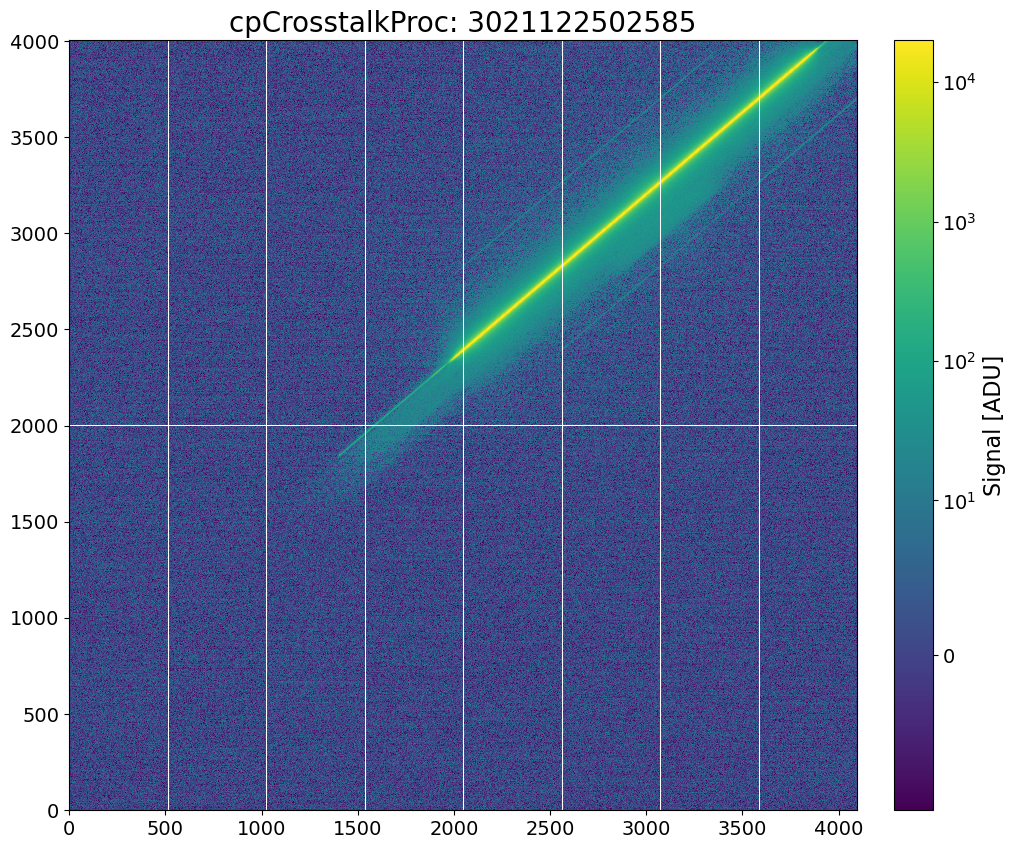

In [5]:
## Define SQL-like repository query
run_num = 13241
detector = 58
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='spot'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)
collections = 'u/snyder18/13241/crosstalk_satellite'

## Get dataset references
dataset_refs = list(registry.queryDatasets('cpCrosstalkProc', where=where, collections=collections))
dataset_refs.sort(key=lambda x: x.dataId['exposure'])

## Get calibrated exposure
ref = dataset_refs[10]
calexp = butler.get('cpCrosstalkProc', dataId=ref.dataId, collections=collections)

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower',
               norm=SymLogNorm(10, vmin=-10, vmax=20000, base=10))

## Overplot segment boundaries
shape = calexp.getImage().getArray().shape
ax.axhline(y=shape[0]//2, color='white', linewidth=0.75)
for i in range(7):
    ax.axvline(x=(shape[1]//8)*(i+1), color='white', linewidth=0.75)
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('cpCrosstalkProc: {0}'.format(ref.dataId['exposure']), fontsize=20)

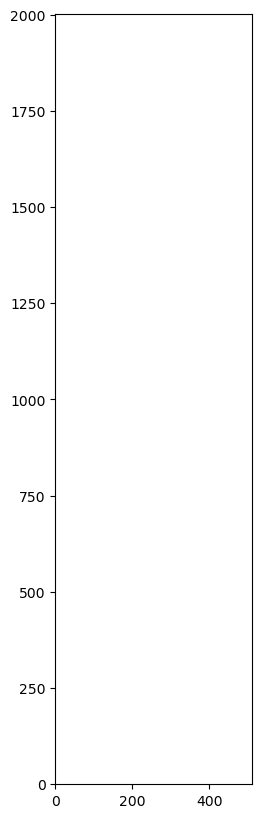

In [13]:
## Select source amplifier
detector = calexp.getDetector()
source_amp = detector[5]

## Get source amp image
source_im = calexp.getMaskedImage()
FootprintSet(source_im, Threshold(1000), "DETECTED")
source_amp_image = source_im[source_amp.getBBox()]
source_amp_array = source_amp_image.getImage().getArray()


## Apply Canny filter on binary detection mask
source_amp_mask = source_amp_image.getMask()
detection_mask = (source_amp_mask.array & source_amp_mask.getPlaneBitMask('DETECTED'))
filter_data = detection_mask.astype(int) 
edges = feature.canny(filter_data, sigma=1.0, low_threshold=0, high_threshold=1)

## Perform Hough Transform and find peaks
tested_angles = np.linspace(-np.pi/2., np.pi/2., 1000)
h, theta, d = hough_line(edges, theta=tested_angles)
accum, angles, dists = hough_line_peaks(h, theta, d)

## Construct Line objects
rhos = []
thetas = []
for i in range(len(angles)):
    angle = angles[i]
    dist = dists[i]
    Ny, Nx = imarr.shape
    x0 = (Nx-1)/2.
    y0 = (Ny-1)/2.
    thetas.append(np.rad2deg(angle))
    rhos.append(dist - x0*np.cos(angle) - y0*np.sin(angle))

lines = LineCollection(rhos, thetas)



In [10]:
help(source_amp_mask)

Help on MaskX in module lsst.afw.image.image object:

class MaskX(ImageBaseI)
 |  Method resolution order:
 |      MaskX
 |      ImageBaseI
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __and__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __iand__(...)
 |      __iand__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __iand__(self: lsst.afw.image.image.MaskX, arg0: lsst.afw.image.image.MaskX) -> lsst.afw